# Authors: Eyal Stolov and Itay Grandenwits

In [1]:
import pandas as pd
import math
from math import pi
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix, mean_squared_error
from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap
import warnings
from scipy import stats
warnings.filterwarnings("ignore")

[Link to dataset](https://archive.ics.uci.edu/dataset/186/wine+quality)

In [2]:
dfr = pd.read_csv('./data/winequality-red.csv', sep=';')
target = 'quality'

### Out Dataset:

In [3]:
dfr.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Our Features:

In [103]:
list(dfr.columns)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

### Each feature range:

In [104]:
for feature in dfr.columns:
    print(f'{feature} - [{min(dfr[feature])}, {max(dfr[feature])}]')

fixed acidity - [4.6, 15.9]
volatile acidity - [0.12, 1.58]
citric acid - [0.0, 1.0]
residual sugar - [0.9, 15.5]
chlorides - [0.012, 0.611]
free sulfur dioxide - [1.0, 72.0]
total sulfur dioxide - [6.0, 289.0]
density - [0.99007, 1.00369]
pH - [2.74, 4.01]
sulphates - [0.33, 2.0]
alcohol - [8.4, 14.9]
quality - [3, 8]


### Lets check for missing values:

In [105]:
dfr.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

#### No missing values!

---

# Dataset Features Explanation

### 1. **Fixed Acidity**
- **Definition**: The non-volatile acids that do not evaporate during fermentation, primarily tartaric acid, which contributes to the tartness of wine.
- **Impact on Wine**: Affects the wine's flavor and preservation. High fixed acidity can make the wine taste sour or sharp, while low fixed acidity might result in a flat taste.
- **Range**: 4.6–15.9 g/L

### 2. **Volatile Acidity**
- **Definition**: Acids that can evaporate, such as acetic acid (the main component of vinegar).
- **Impact on Wine**: High volatile acidity can cause an unpleasant vinegar-like taste, while low levels are essential for a balanced flavor.
- **Range**: 0.12–1.58 g/L

### 3. **Citric Acid**
- **Definition**: A minor acid in wine, often added to enhance freshness and increase acidity.
- **Impact on Wine**: Provides a slight citrusy flavor and enhances the perception of freshness, particularly in white wines.
- **Range**: 0.0–1.0 g/L

### 4. **Residual Sugar**
- **Definition**: The amount of sugar left in wine after fermentation.
- **Impact on Wine**: Determines the sweetness level. Low residual sugar results in a dry wine, while higher levels contribute to sweeter wines.
- **Range**: 0.9–15.5 g/L

### 5. **Chlorides**
- **Definition**: The concentration of chloride ions, which may come from natural sources or winemaking processes.
- **Impact on Wine**: Contributes to the saltiness or minerality of the wine, which can enhance complexity when balanced.
- **Range**: 0.011–0.611 g/L

### 6. **Free Sulfur Dioxide**
- **Definition**: The portion of sulfur dioxide (SO₂) in wine that is not bound to other molecules and is available to act as an antimicrobial and antioxidant agent.
- **Impact on Wine**: Protects wine from oxidation and spoilage, but excessive levels can lead to unpleasant aromas.
- **Typical Range**: 1.0–72.0 mg/L

### 7. **Total Sulfur Dioxide**
- **Definition**: The total amount of sulfur dioxide, both free and bound, present in the wine.
- **Impact on Wine**: Important for preservation, but too much can impair taste and cause health concerns for sensitive individuals.
- **Typical Range**: 6.0 - 289.0 mg/L (regulated by wine type and laws)

### 8. **Density**
- **Definition**: The mass per unit volume of the wine, influenced by sugar and alcohol content.
- **Impact on Wine**: Used to estimate alcohol and residual sugar levels. Higher density often indicates higher sweetness.
- **Typical Range**: 0.99007–1.00369 g/mL

### 9. **pH**
- **Definition**: Measures the acidity level, indicating how acidic or basic the wine is.
- **Impact on Wine**: Affects stability, taste, and color. Lower pH (more acidic) preserves freshness, while higher pH can lead to spoilage if not managed.
- **Range**: 2.74–4.01

### 10. **Sulphates**
- **Definition**: Compounds related to sulfur, often added to wine for preservation.
- **Impact on Wine**: Acts as an antimicrobial and antioxidant, contributing to stability and longevity. Excess levels can impart a bitter or astringent taste.
- **Range**: 0.33–2.0 g/L

### 11. **Alcohol**
- **Definition**: Ethanol content produced during fermentation.
- **Impact on Wine**: Affects body, flavor, and aroma. Higher alcohol content enhances the perception of warmth and boldness.
- **Typical Range**: 8.4–14.9%

### 12. **Quality - Target Feature**
- **Definition**: A subjective score often based on sensory evaluations (e.g., taste, aroma, balance) and sometimes correlated with chemical properties.
- **Impact on Wine**: Serves as an overall indicator of the wine's acceptability and desirability to consumers and critics.
- **Typical Range**: 3–8

---

These traits collectively determine the wine's chemical balance, flavor profile, and market appeal. Winemakers and analysts monitor and adjust these parameters to produce wine of desired quality and style.


---
### Let's start by examining the distibution of the target feature which is "quality":

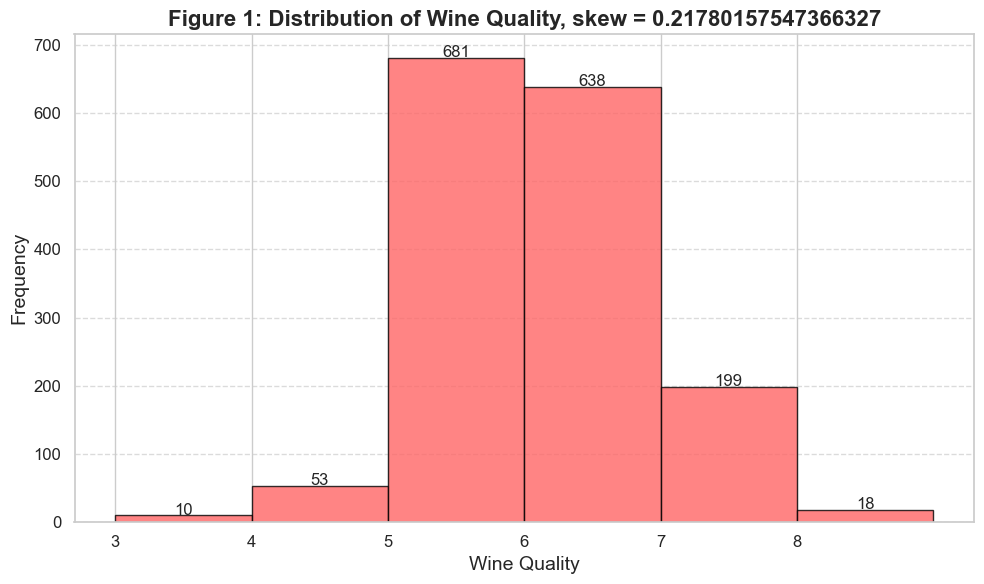

In [106]:
plt.figure(figsize=(10, 6))
counts, bins, bars = plt.hist(
    dfr['quality'], 
    bins=range(dfr['quality'].min(), dfr['quality'].max() + 2), 
    edgecolor='black', 
    color='#FF6666', 
    alpha=0.8
)

plt.title(f'Figure 1: Distribution of Wine Quality, skew = {dfr.quality.skew()}', fontsize=16, weight='bold')
plt.xlabel(f'Wine Quality', fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(range(dfr['quality'].min(), dfr['quality'].max() + 1), fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 1, 
             int(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()


### As we can see most of our data has a quality in between 5-6.
The wine quality scores are almost symmetric but lean slightly towards higher scores. This could imply that most wines in the dataset are of average quality (5 or 6), with a small proportion being exceptional (7 or 8) or poor (3 or 4).


---
### Also,
Since the skewness is low, the distribution is close to normal, meaning statistical methods assuming normality should work well without requiring transformations.

---
### It make sense now then, to check for some specific features that have high correlations with the target feature,
We can start by using a correlations heat map of all the features with the target:

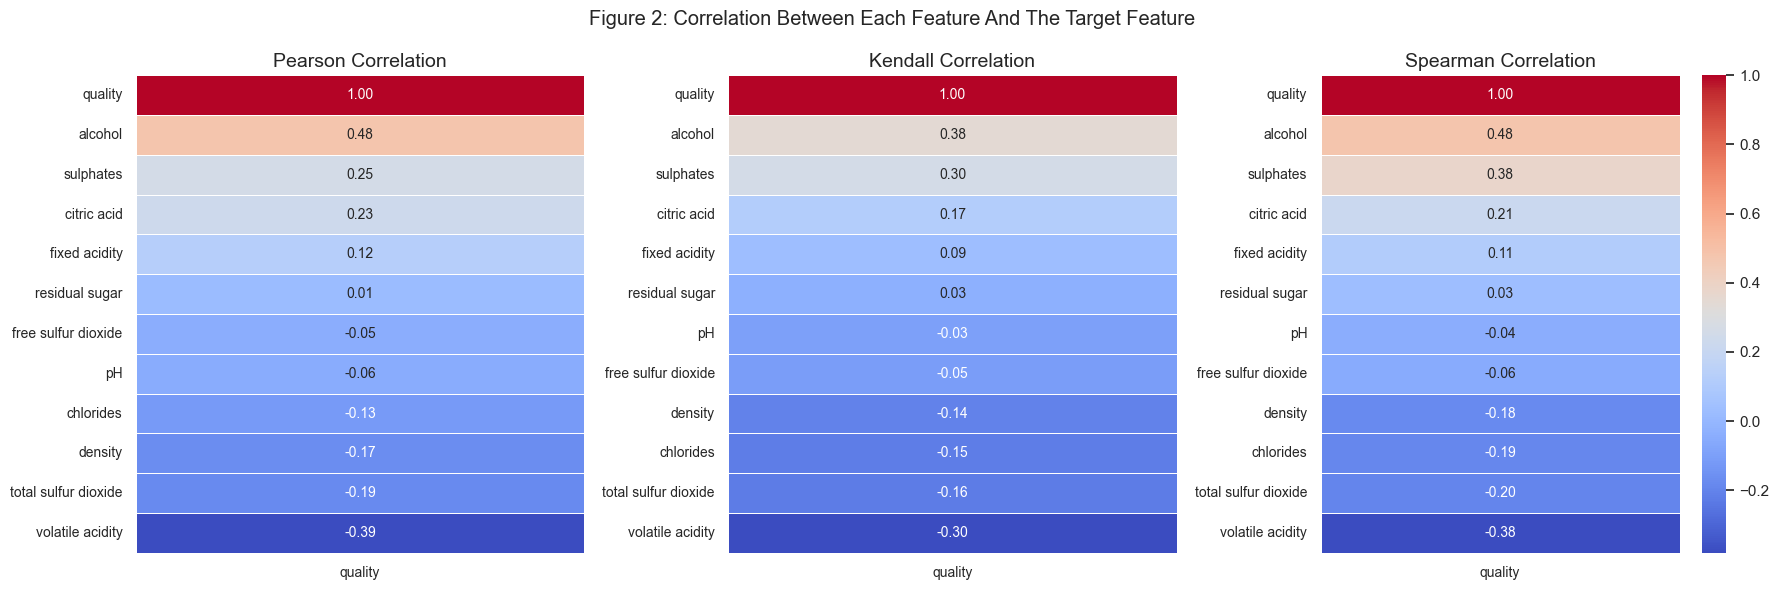

In [107]:
correlation_methods = {
    'Pearson': dfr.corr(method='pearson')[[target]].sort_values(by=target, ascending=False),
    'Kendall': dfr.corr(method='kendall')[[target]].sort_values(by=target, ascending=False),
    'Spearman': dfr.corr(method='spearman')[[target]].sort_values(by=target, ascending=False)
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (method, corr) in enumerate(correlation_methods.items()):
    sns.heatmap(
        corr,
        annot=True,
        cmap='coolwarm',
        cbar=True if i == 2 else False,
        fmt=".2f",
        linewidths=0.5,
        annot_kws={"fontsize": 10},
        ax=axes[i]
    )
    axes[i].set_title(f"{method} Correlation", fontsize=14)
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

plt.suptitle('Figure 2: Correlation Between Each Feature And The Target Feature')
plt.tight_layout()
plt.show()


We checked Pearson, Kendall, and Spearman correlations. We can clearly see the alcohol has some positive effect on the quality of the wine, similarly, sulphates and citric acid both have a weak but still some kind of positive effect as well. On the other hand, volatile acidity has a negative effect on the quality of the wine.

But checking for correlation is not enough, sometimes as intelligent people we might spot correlation that might be unique to this dataset, lets plot each feature with our target feature, and check wether the previous features we found actually have some kind of correlation, and if our correlation tests might have missed some other features.

---
#### The next logical step will be to visulize the Positive and Negative indicators on higher end wines and lower end wines. For that task a spider plot will be perfect, the problem is that not all our features are in the same range. To solve that, we will use the min max scaler.

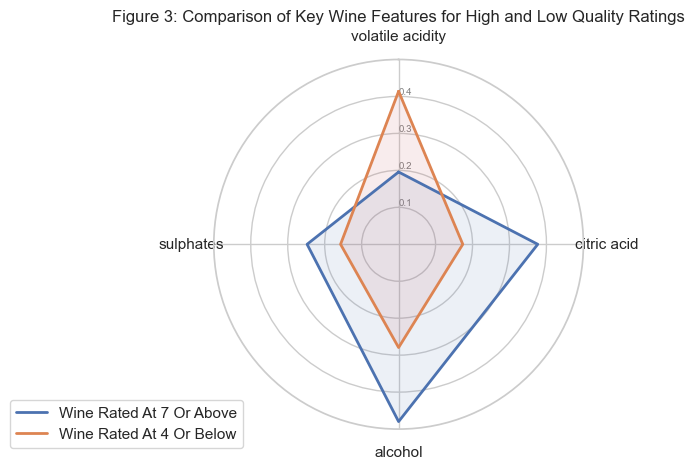

In [108]:
scaler = MinMaxScaler()
standardized_dfr = pd.DataFrame(scaler.fit_transform(dfr),columns=dfr.columns)
dfr_best = standardized_dfr[dfr.quality>=7]
dfr_worst = standardized_dfr[dfr.quality<=4]
categories = ['volatile acidity', 'citric acid', 'alcohol', 'sulphates']
N=len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
ax = plt.subplot(111, polar=True)
 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
ticks = [0.1,0.2,0.3,0.4]
plt.yticks(ticks, [str(num) for num in ticks], color="grey", size=7)
plt.ylim(0,0.5)
 

values=dfr_best[categories].mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Wine Rated At 7 Or Above")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=dfr_worst[categories].mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Wine Rated At 4 Or Below")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title(f'Figure 3: Comparison of Key Wine Features for High and Low Quality Ratings')

plt.show()

### Insights from the Spider Plot

1. **Higher Sulphates**:
   - Wines rated 7 or above have significantly higher sulphate levels. Sulphates act as a preservative, enhancing the wine's longevity and stability, which contributes to its higher quality.

2. **Increased Alcohol Content**:
   - Premium wines (rated 7 or above) consistently feature higher alcohol levels. Alcohol enhances the wine's body, warmth, and sensory experience, making it more appealing.

3. **More Citric Acid**:
   - High-quality wines show elevated citric acid content, which contributes to a fresher and more vibrant flavor profile, enhancing the overall drinking experience.

4. **Lower Volatile Acidity**:
   - The best wines have reduced volatile acidity, resulting in a smoother and more balanced flavor without the sharpness that excessive acidity can bring.


Overall, wines with better ratings are not just about one aspect but a combination of factors—preservation, flavor, and balance—working together to elevate quality.


It's evident that alcohol has the strongest connection to the target feature. This makes it crucial to explore alcohol in greater detail and understand its influence on wine quality.

To gain deeper insights, let's examine how alcohol level is distibuted across different wine qualities using a violin plot:

Text(0.5, 1.0, 'Box Plot Of Alcohol Level Across Different Wine Quality Classes')

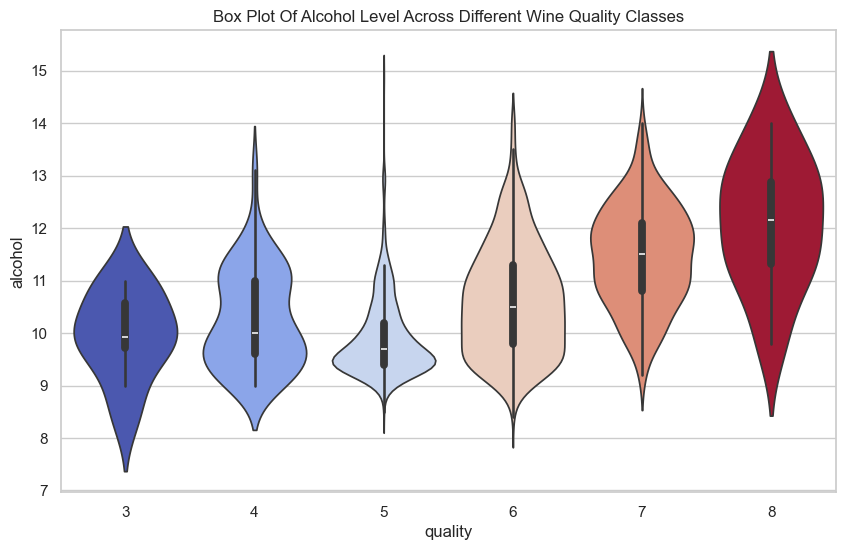

In [109]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=dfr, y ='alcohol',x = target, hue=target, legend=False, palette='coolwarm')
plt.title('Box Plot Of Alcohol Level Across Different Wine Quality Classes')

From those violin plots we can gather some immediate insights about the alcohol and quality features:
__Increasing Alcohol Content with Quality:__ The plot shows a clear upward trend in the median alcohol content as the wine quality improves. Wines rated as higher quality (7 and 8) have higher alcohol levels compared to those with lower ratings (3 and 4).

__Distribution Spread:__ Lower-quality wines (3–5) have relatively narrow distributions, but they still show some variability in alcohol content. Higher-quality wines (6–8) exhibit broader distributions, reflecting more variability in alcohol content among these wines.

### Finding Outliers In The Data
First, let's define what's an outlier on our case:
here, outliers are defined using the Interquartile Range (IQR) method: 

__Q1 and Q3:__ The first and third quartiles (25th and 75th percentiles) of the data are calculated.
__IQR:__ The Interquartile Range is computed as the difference between Q3 and Q1 (i.e., IQR = Q3 - Q1).
__Lower and Upper Bounds:__
The lower bound is calculated as Q1 - 1.5 * IQR.
The upper bound is calculated as Q3 + 1.5 * IQR.
__Outlier Identification:__ Any data points that fall outside these bounds (i.e., smaller than the lower bound or greater than the upper bound) are considered outliers.

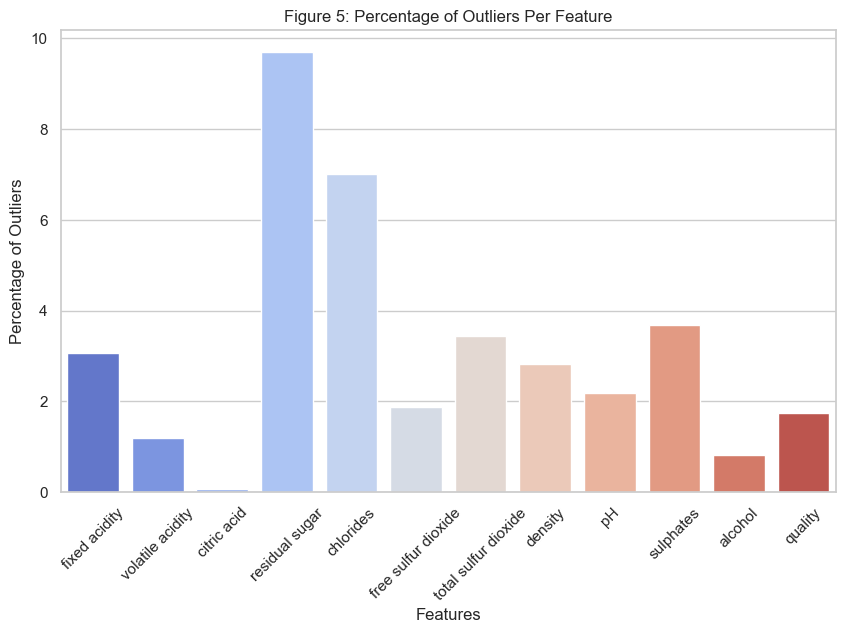

In [110]:
def percent_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_number = ((series < lower_bound) | (series > upper_bound)).sum()
    return 100 * outliers_number / len(series)

outlier_counts = dfr.apply(percent_outliers).reset_index()
outlier_counts.columns = ['Feature', 'Outlier_Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=outlier_counts, x="Feature",hue ='Feature', y="Outlier_Count", palette="coolwarm")

plt.xticks(rotation=45)
plt.title("Figure 5: Percentage of Outliers Per Feature")
plt.ylabel("Percentage of Outliers")
plt.xlabel("Features")
plt.show()

The analysis reveals that Residual Sugar has 10% outliers, while Chlorides exhibit 7% outliers:

### Residual Sugar (10% Outliers):

A high proportion of outliers indicates that some wines have residual sugar levels that deviate significantly from the typical range.
This could suggest the presence of dessert wines or sweet wines, which naturally have much higher sugar content than table wines.
These outliers may hold critical information about specific wine types and their quality. Instead of discarding this feature, it make sense then to analyze outliers separately to identify unique patterns in wine quality.

### Chlorides (7% Outliers):

Chlorides are typically associated with saltiness in wine, and their outliers might indicate wines with unusually high chloride content, potentially due to specific winemaking practices or environmental factors (e.g., saline soils).
While the percentage of outliers is lower than Residual Sugar, these deviations could still influence the perception of wine quality and should be investigated further.


---

# Basic Model Pipeline

In [111]:
X = dfr.drop(columns=[target])
y = dfr[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Let's verify that both the train samples and the test samples distribute the same:

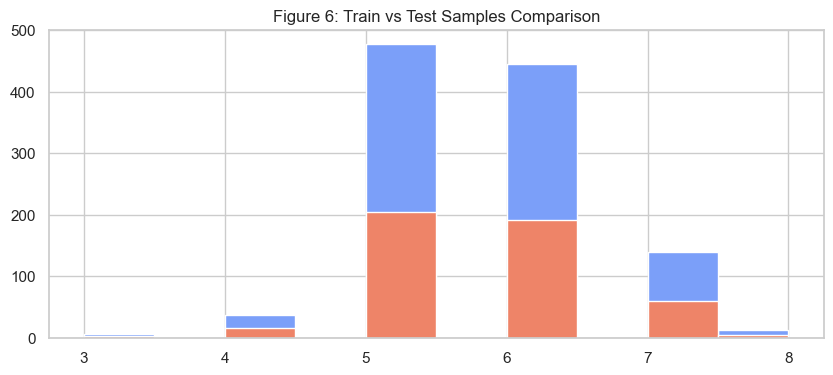

In [112]:

fig, ax = plt.subplots(figsize=(10,4))
y_train.hist(ax=ax, color=plt.cm.coolwarm(0.2))
y_test.hist(ax=ax, color=plt.cm.coolwarm(0.8))
plt.title('Figure 6: Train vs Test Samples Comparison')
plt.show()

We can see that the train and test sets indeed distibute similarly, so we can continue to train our model:

In [113]:
model = xgb.XGBRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#To get the actual qualitys
y_pred_rounded = np.array([])
for pred in y_pred:
    y_pred_rounded = np.append(y_pred_rounded, round(pred))
    
#index the predictions
y_pred_indexed = pd.Series(y_pred, y_test.index)

# __Note:__
We didn't transform any features of the data on purpose, that's because we wanted to have medium results so we'll be able to imporove it on the next stage of the project (that's on the exrecise instructions).

---

# Error Analysis

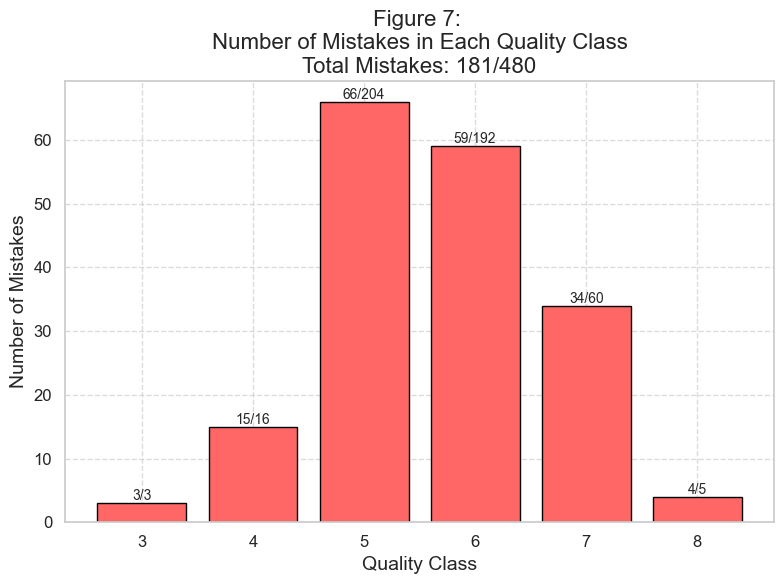

In [114]:
classes = [3, 4, 5, 6, 7, 8]
amount_of_classes_in_each_class = np.unique(y_test, return_counts=True)[1]

mistakes = []
for i, label in enumerate(classes):
    mistakes.append(np.sum((y_test == label) & (y_pred_rounded != label)))

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
plt.bar(classes, mistakes, color='#FF6666', edgecolor='black')

for i, height in enumerate(mistakes):
    plt.text(classes[i], height, f'{height}/{amount_of_classes_in_each_class[i]}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Quality Class', fontsize=14)
plt.ylabel('Number of Mistakes', fontsize=14)
plt.title(f'Figure 7: \nNumber of Mistakes in Each Quality Class\nTotal Mistakes: {np.sum(mistakes)}/{len(y_test)}', fontsize=16)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Our mistakes distibution is similar to the quality distibution, this is logical because we used the stratify method when spliting to test and train. \
Its obvious we have the **most mistakes for wines rated at 5**, but we can see our model **generilizes the worst for wines rated at 3, 4 and 8**, this can be explained by the fact that those classes have reletivly small amout of samples for the model to train on. \
Also, we can spot that wines rated at 7 also have bad accuracy but better then 3,4 and 8.

---
# Is the model overestimating or underestimating?

In [115]:
residuals = y_test - y_pred

positive_residuals = np.sum(residuals > 0)
negative_residuals = np.sum(residuals < 0)

mean_residual = np.mean(residuals)

t_stat, p_value = stats.ttest_1samp(residuals, 0)

print(f"Number of positive residuals: {positive_residuals}")
print(f"Number of negative residuals: {negative_residuals}")
print(f"Mean residual: {mean_residual}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

Number of positive residuals: 240
Number of negative residuals: 240
Mean residual: -0.012908471127351126
T-statistic: -0.46074436259100365, P-value: 0.6451911338147853


__Positive vs Negative Residuals:__ Equal number of positive and negative residuals (240 each), indicating balanced overestimation and underestimation.
__Mean Residual:__ Close to zero (-0.0129), suggesting no overall bias in the model's predictions.
__T-test Results:__ T-statistic of -0.4607 and p-value of 0.6452, meaning no significant bias toward overestimating or underestimating.
__Conclusion:__
The model does not show a consistent tendency to overestimate or underestimate, with balanced residuals and no significant bias.

---
# The Model's Metrics:

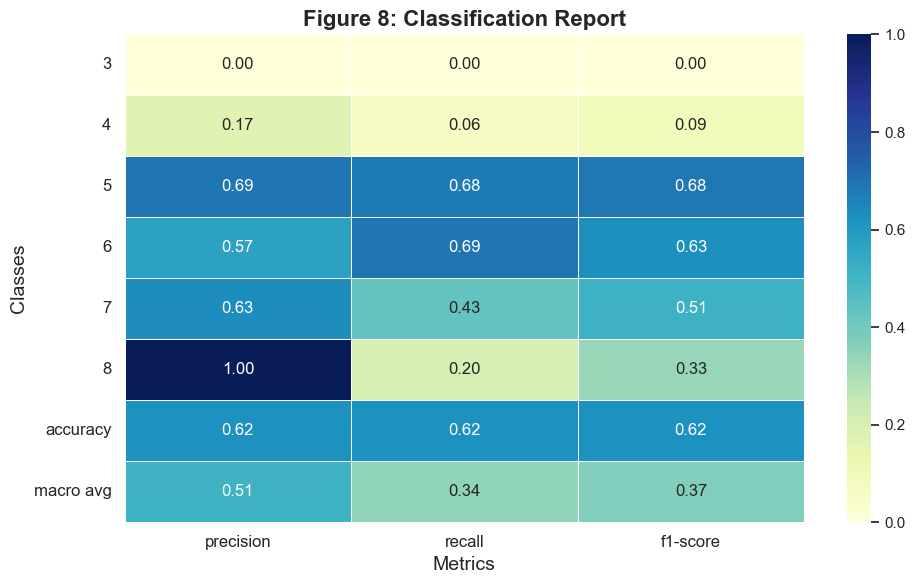

In [116]:
report = classification_report(
    y_test, y_pred_rounded, target_names=['3', '4', '5', '6', '7', '8'], output_dict=True
)

df_report = pd.DataFrame(report).transpose()

df_report = df_report.drop(columns=['support'], errors='ignore')

plt.figure(figsize=(10, 6))
sns.heatmap(
    df_report.iloc[:-1, :].astype(float),
    annot=True, cmap="YlGnBu", cbar=True, fmt=".2f", linewidths=0.5,
)

plt.title('Figure 8: Classification Report', fontsize=16, weight='bold')
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Classes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()

plt.show()


**Class Performance**:  
   - **Class 3** and **Class 4** have very low scores, indicating poor prediction.  
   - **Class 5** and **Class 6** perform the best, with balanced precision and recall

   - The model struggles with underrepresented classes (**3**, **4**, and **8**).  
   - Imbalance in recall highlights missed predictions.  
   

---
# Top 10 Samples with the worst mistake margin:
Lets check which samples the model predicts the worst, in the following the colored cells are outliers by the IQR outlier method

### __NOTE__:
To see highlighted cells you must run the notebook

In [117]:
def calculate_iqr_ranges(dataframe):
    iqr_ranges = {}
    for column in dataframe.columns:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_ranges[column] = (lower_bound, upper_bound)
    return iqr_ranges

iqr_ranges = calculate_iqr_ranges(dfr)

def style_outliers(df, ranges, color):
    def highlight(val, col):
        lower_bound, upper_bound = ranges.get(col, (None, None))
        if lower_bound is not None and (val < lower_bound or val > upper_bound) and (col!='quality'):
            return f'background-color: {color}'
        return ''
    
    return df.style.apply(lambda col: [highlight(val, col.name) for val in col], axis=0)

In [118]:
largest_mistakes = np.absolute(y_test - y_pred).nlargest(10)
largest_mistakes_df = dfr.iloc[largest_mistakes.index]
largest_mistakes_df['predicted_quality'] = y_pred_indexed
largest_mistakes_df['mistake_margin'] = (y_test - y_pred)[largest_mistakes.index]

style_outliers(largest_mistakes_df, iqr_ranges, 'orange')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,predicted_quality,mistake_margin
1374,6.800000,0.815000,0.000000,1.200000,0.267000,16.000000,29.000000,0.994710,3.320000,0.510000,9.800000,3,5.314950,-2.314950
440,12.600000,0.310000,0.720000,2.200000,0.072000,6.000000,29.000000,0.998700,2.880000,0.820000,9.800000,8,6.009309,1.990691
756,6.300000,0.980000,0.010000,2.000000,0.057000,15.000000,33.000000,0.994880,3.600000,0.460000,11.200000,6,4.037154,1.962846
861,5.800000,1.010000,0.660000,2.000000,0.039000,15.000000,88.000000,0.993570,3.660000,0.600000,11.500000,6,4.065419,1.934581
876,7.100000,0.470000,0.000000,2.200000,0.067000,7.000000,14.000000,0.995170,3.400000,0.580000,10.900000,4,5.917571,-1.917571
647,8.300000,0.845000,0.010000,2.200000,0.070000,5.000000,14.000000,0.996700,3.320000,0.580000,11.000000,4,5.779135,-1.779135
703,7.500000,0.380000,0.480000,2.600000,0.073000,22.000000,84.000000,0.997200,3.320000,0.700000,9.600000,4,5.639214,-1.639214
832,10.400000,0.440000,0.420000,1.500000,0.145000,34.000000,48.000000,0.998320,3.380000,0.860000,9.900000,3,4.634234,-1.634234
1089,11.600000,0.410000,0.540000,1.500000,0.095000,22.000000,41.000000,0.997350,3.020000,0.760000,9.900000,7,5.429718,1.570282
1088,11.600000,0.410000,0.540000,1.500000,0.095000,22.000000,41.000000,0.997350,3.020000,0.760000,9.900000,7,5.429718,1.570282


It seems that the chlorides feature might be affecting our models performence. In the next stage it might help to standardize this feature

Moreover, it seems the 'alcohol' feature, which had the strongest correaltion with our target feature, does not have outliers here.

# Top 10 Samples with the best mistake margin:
Similarly, lets check which samples the model predicts the best

In [119]:
smallest_mistakes = np.absolute(y_test - y_pred).nsmallest(10)
smallest_mistakes_df = dfr.iloc[smallest_mistakes.index]
smallest_mistakes_df['predicted_quality'] = y_pred_indexed
smallest_mistakes_df['mistake_margin'] = (y_test - y_pred)[smallest_mistakes.index]
smallest_mistakes_df

style_outliers(smallest_mistakes_df, iqr_ranges, 'green')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,predicted_quality,mistake_margin
580,12.300000,0.500000,0.490000,2.200000,0.089000,5.000000,14.000000,1.000200,3.190000,0.440000,9.600000,5,4.999880,0.000120
854,9.300000,0.360000,0.390000,1.500000,0.080000,41.000000,55.000000,0.996520,3.470000,0.730000,10.900000,6,5.999805,0.000195
851,9.300000,0.430000,0.440000,1.900000,0.085000,9.000000,22.000000,0.997080,3.280000,0.550000,9.500000,5,4.999273,0.000727
1596,6.300000,0.510000,0.130000,2.300000,0.076000,29.000000,40.000000,0.995740,3.420000,0.750000,11.000000,6,6.000739,-0.000739
1493,7.700000,0.540000,0.260000,1.900000,0.089000,23.000000,147.000000,0.996360,3.260000,0.590000,9.700000,5,4.999097,0.000903
112,8.400000,0.600000,0.100000,2.200000,0.085000,14.000000,111.000000,0.996400,3.150000,0.660000,9.800000,5,4.998952,0.001048
324,10.000000,0.490000,0.200000,11.000000,0.071000,13.000000,50.000000,1.001500,3.160000,0.690000,9.200000,6,5.998581,0.001419
836,6.700000,0.280000,0.280000,2.400000,0.012000,36.000000,100.000000,0.990640,3.260000,0.390000,11.700000,7,6.998369,0.001631
1173,7.600000,0.360000,0.310000,1.700000,0.079000,26.000000,65.000000,0.997160,3.460000,0.620000,9.500000,6,6.001718,-0.001718
555,15.500000,0.645000,0.490000,4.200000,0.095000,10.000000,23.000000,1.003150,2.920000,0.740000,11.100000,5,5.001739,-0.001739


Obviously, in the next exercise we will standardize the density feature, but we can also see right here that it might have a positive relationship with our target feature, lets check the feature importances

---
# Feature Importance

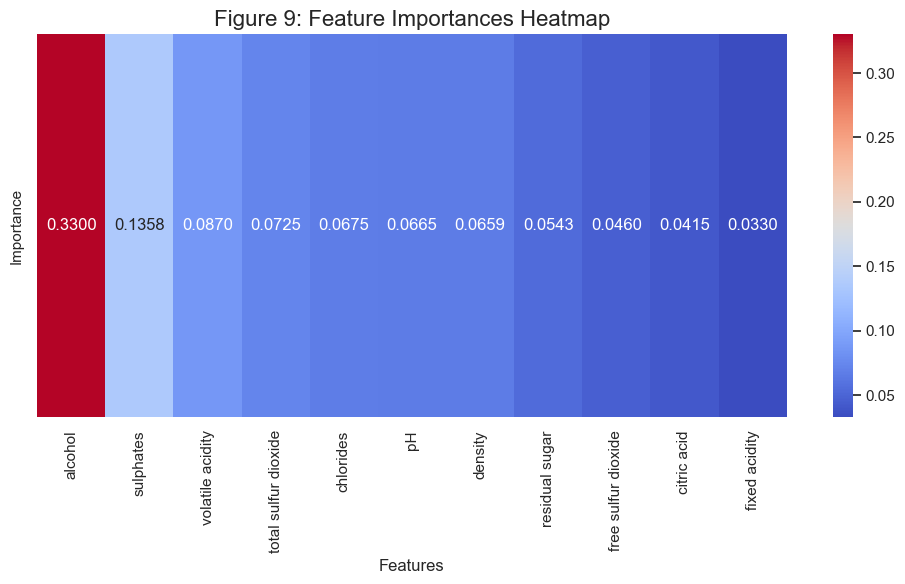

In [120]:
feature_importances = model.feature_importances_

sorted_importances = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)

importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

plt.figure(figsize=(10, 6))
sns.heatmap(importance_df.set_index('Feature').T, cmap='coolwarm', annot=True, fmt='.4f', cbar=True)
plt.title('Figure 9: Feature Importances Heatmap', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.tight_layout()
plt.show()


This heatmap displays the **feature importance scores** generated by the XGBoost model. It highlights the relative contribution of each feature to the model's predictions.

**Top Feature - Alcohol**:  
   - **Alcohol** has the highest importance score of **0.33**.  
   - This confirms that **alcohol** is the most influential feature driving the model's predictions.

   - With an importance score of **0.1358**, sulphates rank second in significance.  
   - While less impactful than alcohol, it still contributes substantially to the model's performance.

**Least Important Features**:  
   - **Free sulfur dioxide**, **citric acid**, and **fixed acidity** have the lowest importance scores.  
   - These features contribute minimally to the model predictions compared to the top-ranked features.
   
**Chlorides**
   - It seems **chlorides** helps the model more then other features, so even if 3/10 of the worst predicted samples have chlorides as outliers, it looks like transforming this feature will make it much more helpful to the model

# Underfitting vs Overfitting check

In [121]:
y_train_pred = model.predict(X_train)

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
val_rmse = mean_squared_error(y_test, y_pred_rounded, squared=False)

print(f"Training RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")

Training RMSE: 0.03569537062313207
Validation RMSE: 0.672371425131477


The **Validation RMSE > Training RMSE** indicating that the model is overfitting

# Further Reading
The content you just explored represents the culmination of our work.
Throughout our journey, we delved into various aspects of the data to gain a deeper understanding. Here are some of the key areas we investigated:

After we examined to correlation between each feature and the target (Figure 1),
we wanted to deepen our understaing of the relationships between the feature and the quality on the wines: examination of

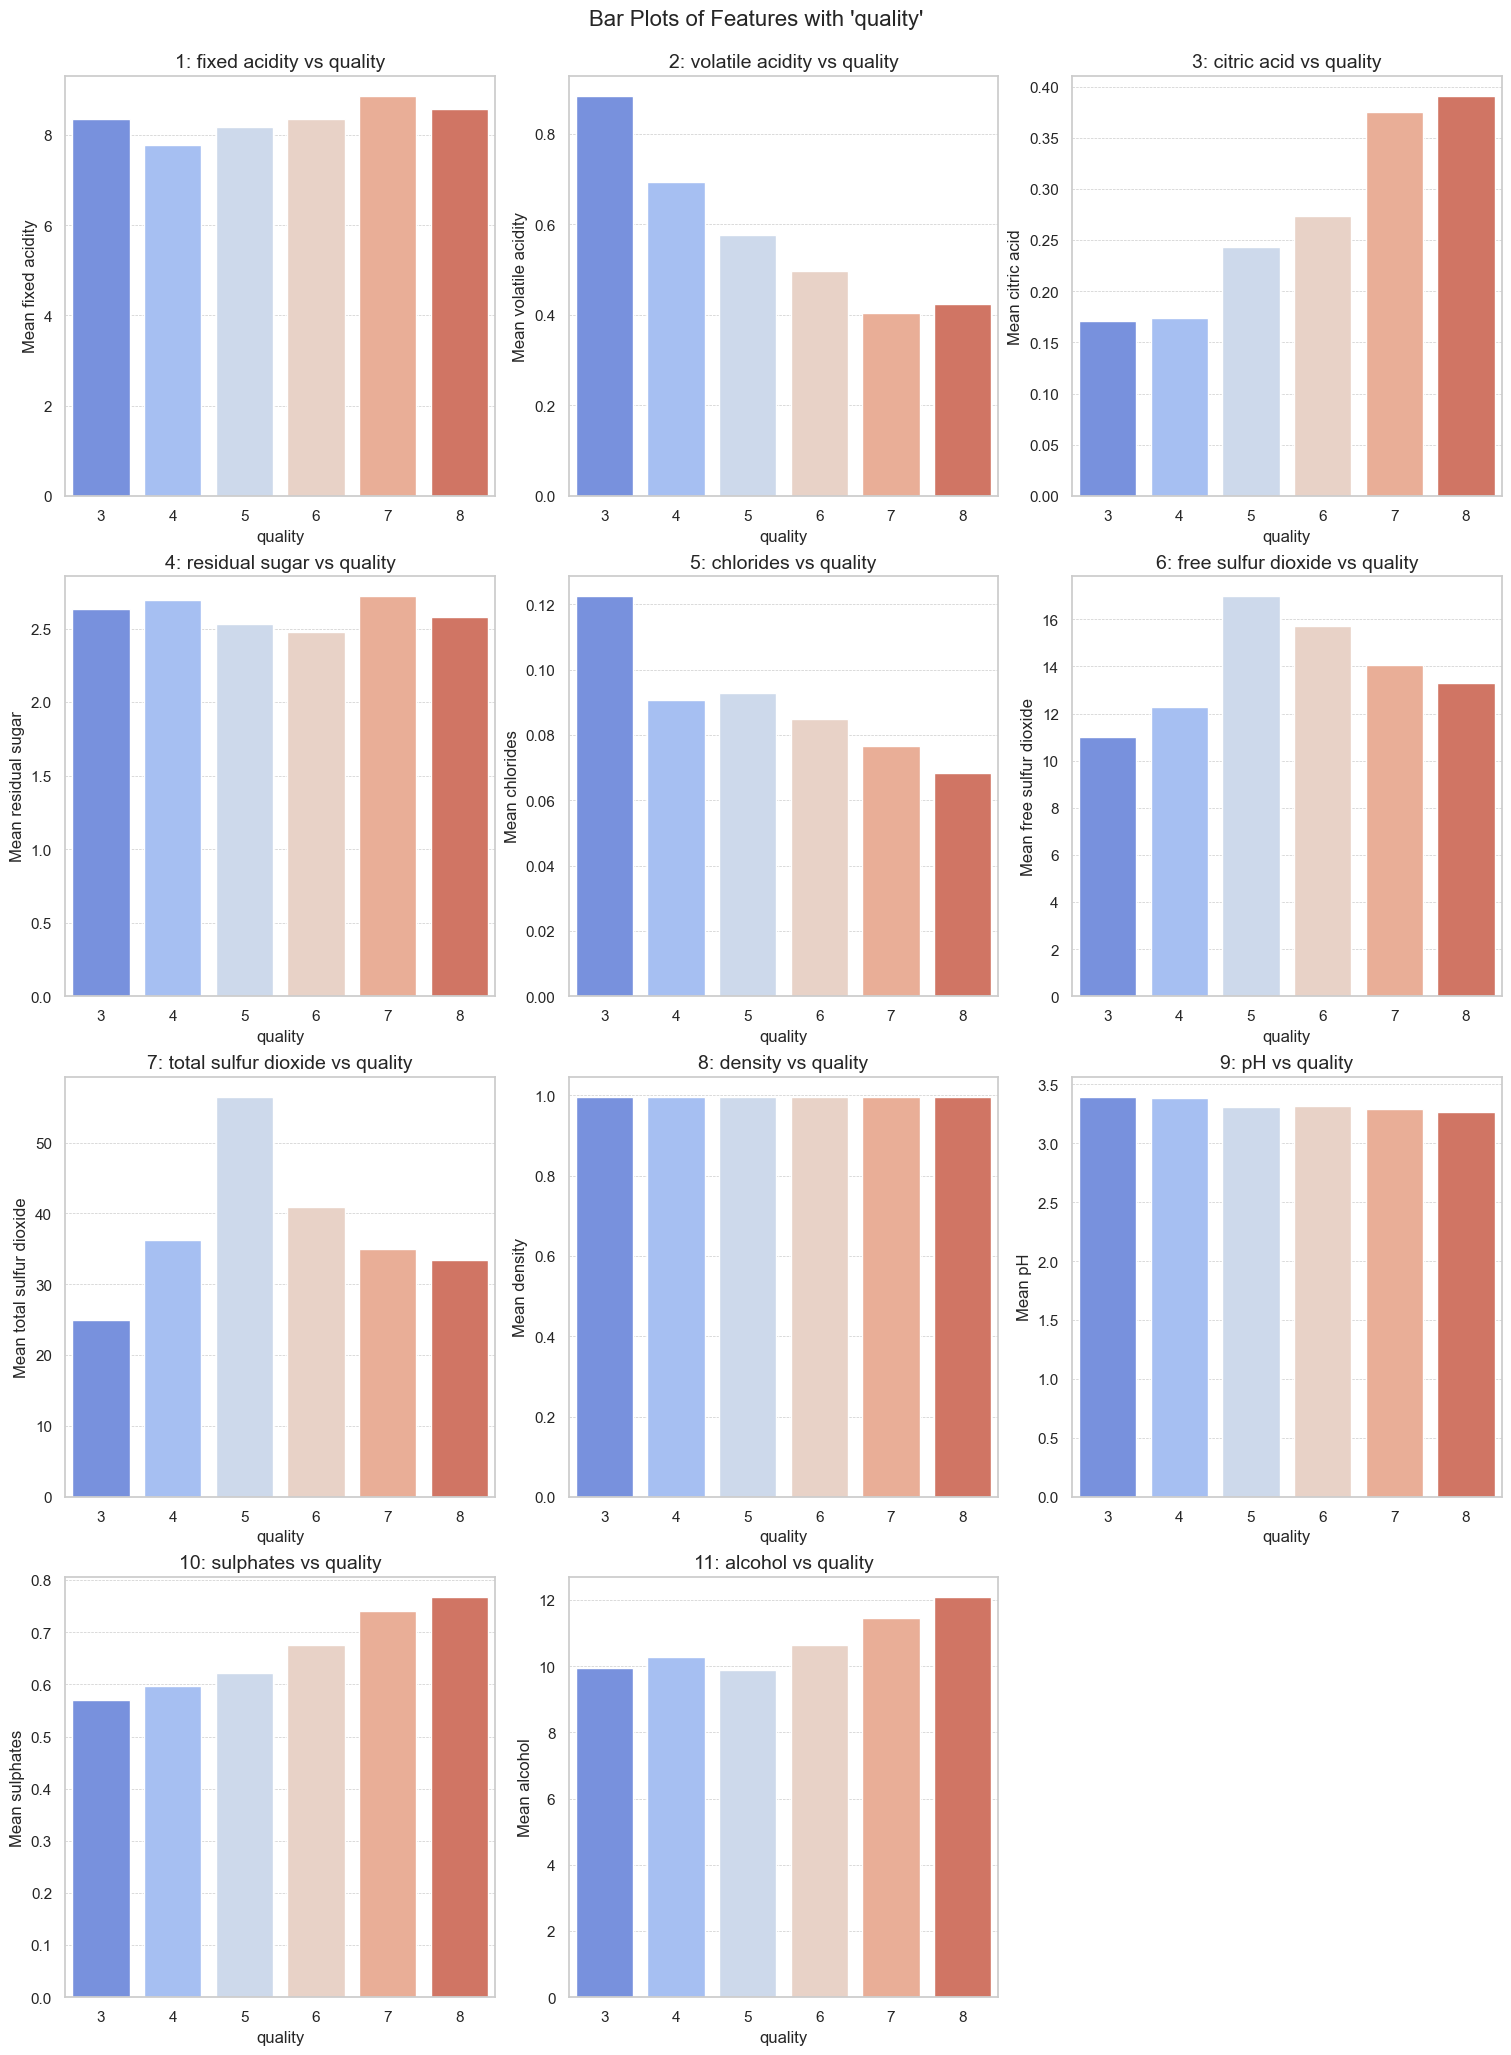

In [122]:
features = [col for col in dfr.columns if col != target]
num_features = len(features)
cols = 3
rows = (num_features + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    feature_means = dfr.groupby(target)[feature].mean().reset_index()
    sns.barplot(data=feature_means, x=target, y=feature, ax=ax, palette='coolwarm')
    ax.set_title(f"{i+1}: {feature} vs {target}", fontsize=14)
    ax.set_xlabel(target, fontsize=12)
    ax.set_ylabel(f"Mean {feature}", fontsize=12)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle(f"Bar Plots of Features with '{target}'", fontsize=16, y=1.02)
plt.show()

# Insights for Each Plot

### 1. Fixed Acidity vs Quality
- Fixed acidity shows no clear trend as wine quality increases.
- Wines with all quality levels have similar average fixed acidity values, suggesting it may not strongly influence quality.

### 2. Volatile Acidity vs Quality
- There is a clear negative correlation between volatile acidity and wine quality.
- Lower volatile acidity is associated with higher-quality wines.

### 3. Citric Acid vs Quality
- Citric acid levels tend to increase as wine quality improves.
- Higher-quality wines have higher citric acid content, suggesting it may positively influence quality.

### 4. Residual Sugar vs Quality
- Residual sugar shows little variation across quality levels.
- This feature likely does not significantly impact wine quality.

### 5. Chlorides vs Quality
- Chloride levels show a slight negative trend as quality improves.
- Lower chlorides may be slightly associated with better-quality wines.

### 6. Free Sulfur Dioxide vs Quality
- Free sulfur dioxide shows minimal variation across quality levels.
- It likely has a weak or negligible effect on wine quality.

### 7. Total Sulfur Dioxide vs Quality
- Higher levels of total sulfur dioxide are associated with lower-quality wines.
- A decrease in total sulfur dioxide may positively influence wine quality.

### 8. Density vs Quality
- Density does not vary significantly with quality, remaining fairly constant across all levels.
- It may not be a strong predictor of wine quality.

### 9. pH vs Quality
- The pH levels remain consistent across different wine quality levels.
- This indicates a limited relationship between pH and wine quality.

### 10. Sulphates vs Quality
- Sulphate levels increase as wine quality improves.
- Higher sulphates appear to be a positive indicator of better wine quality.

### 11. Alcohol vs Quality
- Alcohol content has a strong positive correlation with wine quality.
- Higher-quality wines generally have higher alcohol content.

---

# General Observations
- **Key Positive Indicators**: Alcohol, sulphates, and citric acid are associated with better wine quality.
- **Key Negative Indicators**: Volatile acidity is negatively correlated with wine quality.
- **Neutral Features**: Features like residual sugar, free sulfur dioxide, density, and pH show minimal influence on quality.
- **Wierd Features**:  Total sulfur dioxide has looks like it distrubtes like a normal distibution for quality, where the averages wine have the most total sulfar dioxide

This and the insight from Figure 1 and Figure 3, has lead us to the understaing that Volatile Acidity and Espacially Alcohol had somthing to do with 
the quality of the wines. Hence, we wanted to look at the realtionship between those 2 features.

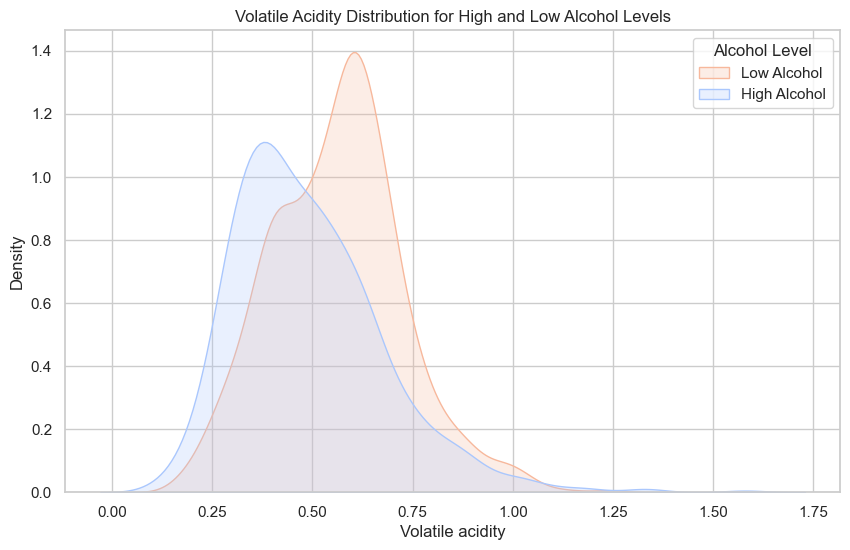

In [123]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=dfr, x='volatile acidity', hue=dfr['alcohol'] <= dfr['alcohol'].median(), fill=True, palette='coolwarm')
plt.title('Volatile Acidity Distribution for High and Low Alcohol Levels')
plt.xlabel('Volatile acidity')
plt.ylabel('Density')
plt.legend(['Low Alcohol', 'High Alcohol'], title='Alcohol Level')
plt.show()

Wines with lower alcohol levels tend to have higher volatile acidity, which negatively impacts quality. Since alcohol positively correlates with quality, this relationship suggests that higher alcohol wines may undergo better fermentation processes, reducing acidity and enhancing overall flavor balance.

From figure 5 it was clearly shown that residual sugar and chlorides are the top features that contains outliers,
Then, it make sense to usue box plots to view where those outliers actually are.

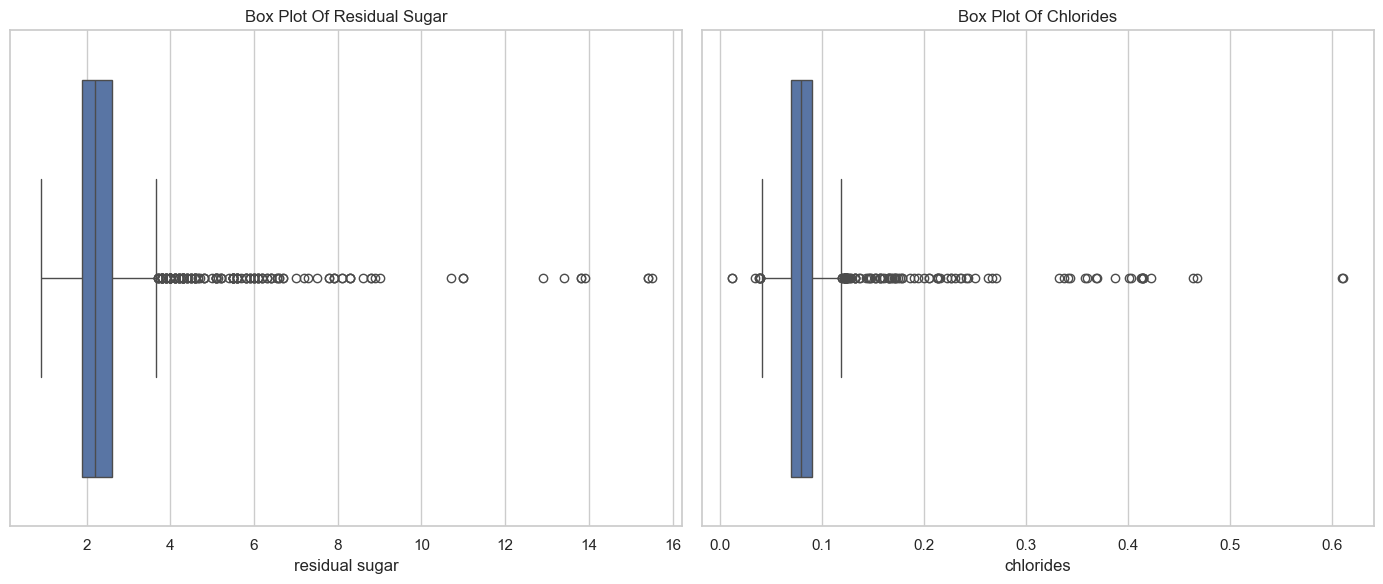

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x=dfr['residual sugar'], ax=axes[0])
axes[0].set_title('Box Plot Of Residual Sugar')

sns.boxplot(x=dfr['chlorides'], ax=axes[1])
axes[1].set_title('Box Plot Of Chlorides')

plt.tight_layout()
plt.show()


Both residual sugar and chlorides exhibit outliers that are predominantly above the upper bound of the interquartile range (IQR). This suggests that extreme values for these features tend to be unusually high rather than unusually low.

Such a pattern could indicate that high levels of residual sugar and chlorides are relatively rare but may play a significant role in differentiating specific wine qualities or types. For example:

Elevated residual sugar could be associated with sweeter wines, which deviate from the typical distribution.
High chloride levels may point to anomalies in production or environmental factors, such as water salinity or preservation techniques.



We can also examine those outliers over different wine qualities:

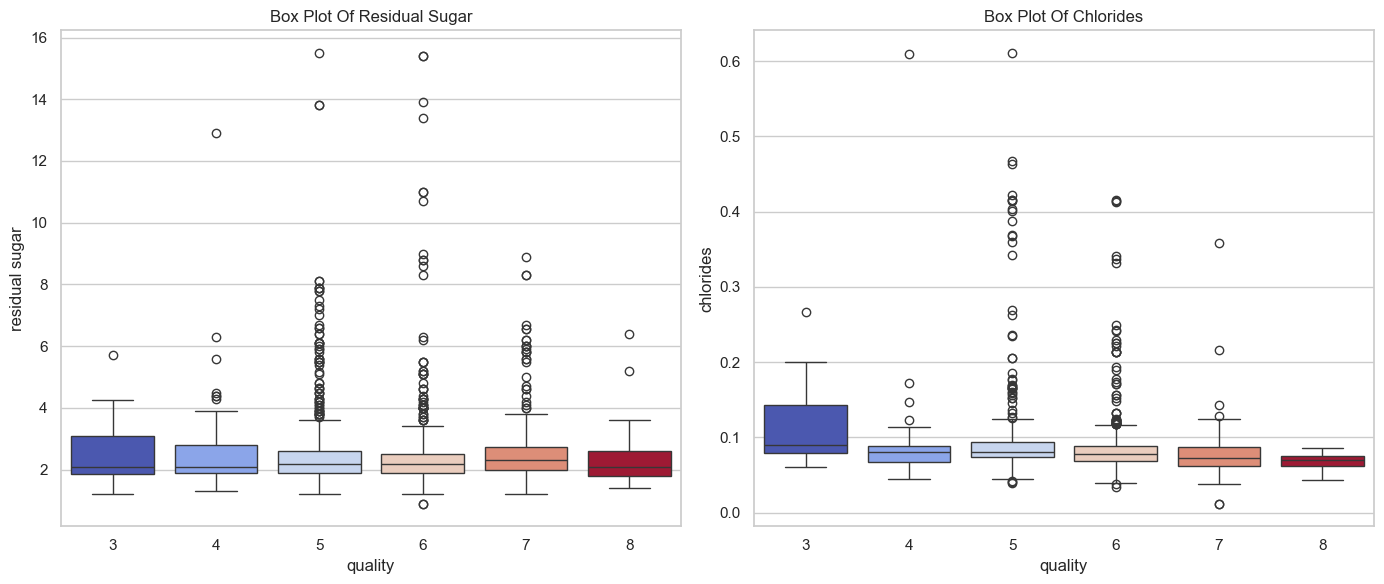

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=dfr, y ='residual sugar',x = target, hue=target, ax=axes[0], legend=False, palette='coolwarm')
axes[0].set_title('Box Plot Of Residual Sugar')

sns.boxplot(data=dfr, y ='chlorides', x = target, hue=target, ax=axes[1], legend=False, palette='coolwarm')
axes[1].set_title('Box Plot Of Chlorides')


plt.tight_layout()
plt.show()

It's not surprising that most outliers are found in qualities 5-6, as these categories contain the majority of the data.
However, the interesting insight from this plot is the significant number of outliers in residual sugar for quality = 7.
A plausible explanation for this could be that certain individuals have a strong preference for sweeter wines.

# Refrences

https://www.kaggle.com/code/nkitgupta/feature-engineering-and-feature-selection/notebook


ChatGPT was used to help with:
1. Learning how to highlight the cells in a dataframe
2. Improving readablity of some insights throughout the notebook
3. Learning how to improve colors in plots